In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("trip_count_sql").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/03 10:00:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# 디렉토리 지정
directory="/home/ubuntu/working/spark-examples/data"
trip_files="trips/*" # trips 디렉토리 내의 모든 파일을 불러오기
zone_file ="taxi+_zone_lookup.csv"

trips_df = spark.read.csv(f"file://{directory}/{trip_files}", inferSchema=True, header=True)
zone_df  = spark.read.csv(f"file://{directory}/{zone_file}", inferSchema=True, header=True)

TempView 등록 하기

In [3]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

Warehouse 구축

In [4]:
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
    
FROM trips t
LEFT JOIN
    zone pz
ON t.PULocationID = pz.LocationID
LEFT JOIN
    zone dz
ON t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")

단순히 Lake 데이터를 사용해서 Warehouse를 만들게 되면, 이상치나 오류 데이터가 아직까지는 많이 있는 상황
- 정제를 통해 머신러닝이나 EDA를 할 수 있는 형식으로 데이터를 정제
- 이렇게 만들어진 데이터 세트를 Mart라고 한다.

In [5]:
# Data 정제
query = """
SELECT *
FROM comb c
WHERE c.total_amount < 5000
  AND c.total_amount > 0
  AND c.passenger_count < 5
  AND c.pickup_date >= '2021-01-01'
  AND c.pickup_date < '2021-08-01'
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

# matplotlib으로 시각화

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# pickup_date 별 운행 수 확인
query = """
SELECT pickup_date, count(pickup_date) as trips
FROM cleaned
GROUP BY pickup_date
"""

# 쿼리 실행의 결과를 판다스 데이터프레임으로 바꿔서 시각화 수행
trips_pdf = spark.sql(query).toPandas()

In [8]:
trips_pdf.head()

,pickup_date,trips
0,2021-03-22,53031
1,2021-03-07,34865
2,2021-03-21,40258
3,2021-05-27,84245
4,2021-03-14,39323


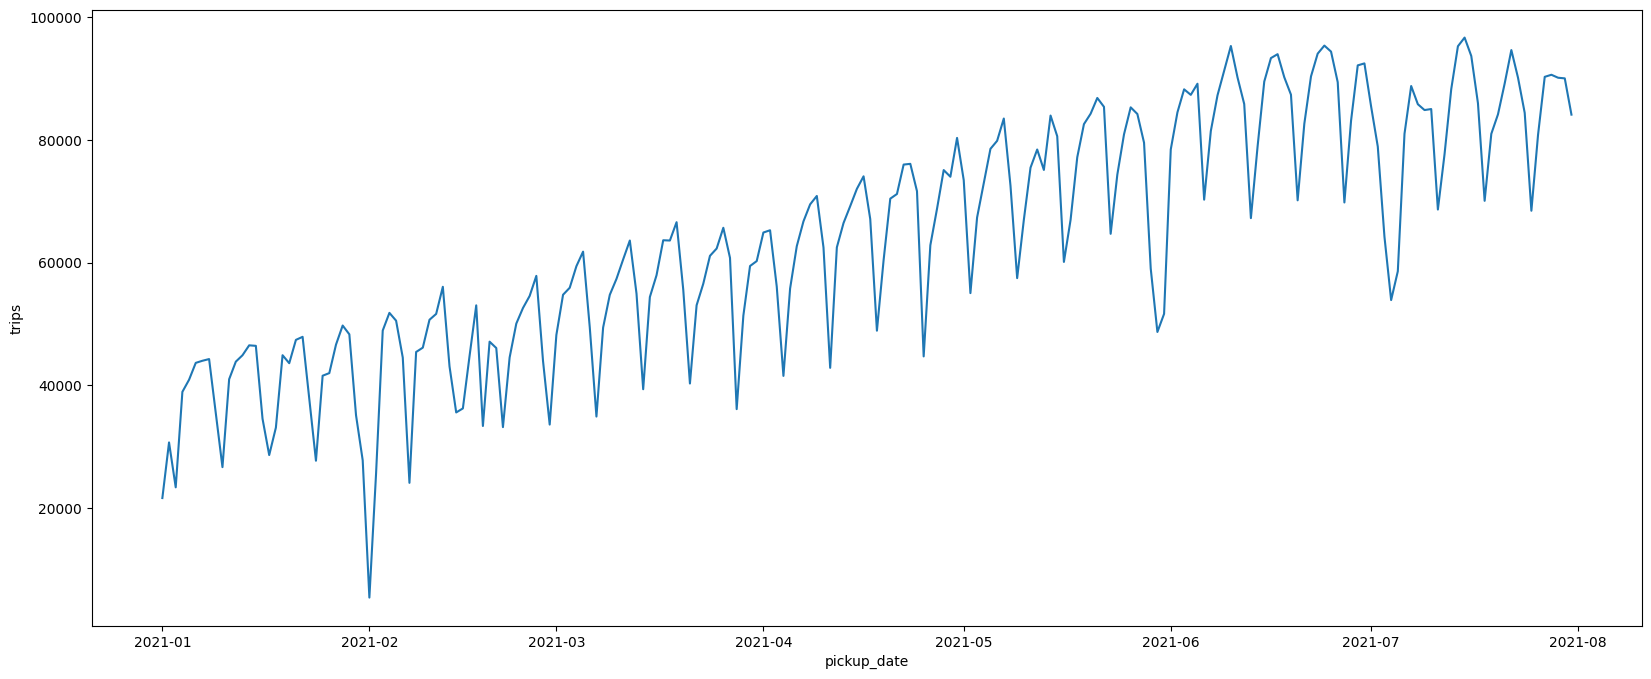

In [9]:
plt.subplots(figsize=(20, 8))
sns.lineplot(x='pickup_date', y='trips', data=trips_pdf)
plt.show()

In [10]:
# 요일 별 택시 카운트 확인
query = """
SELECT pickup_date,
       DATE_FORMAT(pickup_date, 'EEEE') as day_of_week,
       count(*) as trips
FROM cleaned
GROUP BY pickup_date, day_of_week
"""

trips_day_of_week_pdf = spark.sql(query).toPandas()
trips_day_of_week_pdf.head()

,pickup_date,day_of_week,trips
0,2021-03-24,Wednesday,61095
1,2021-03-03,Wednesday,55886
2,2021-03-05,Friday,61779
3,2021-03-09,Tuesday,54732
4,2021-03-26,Friday,65675


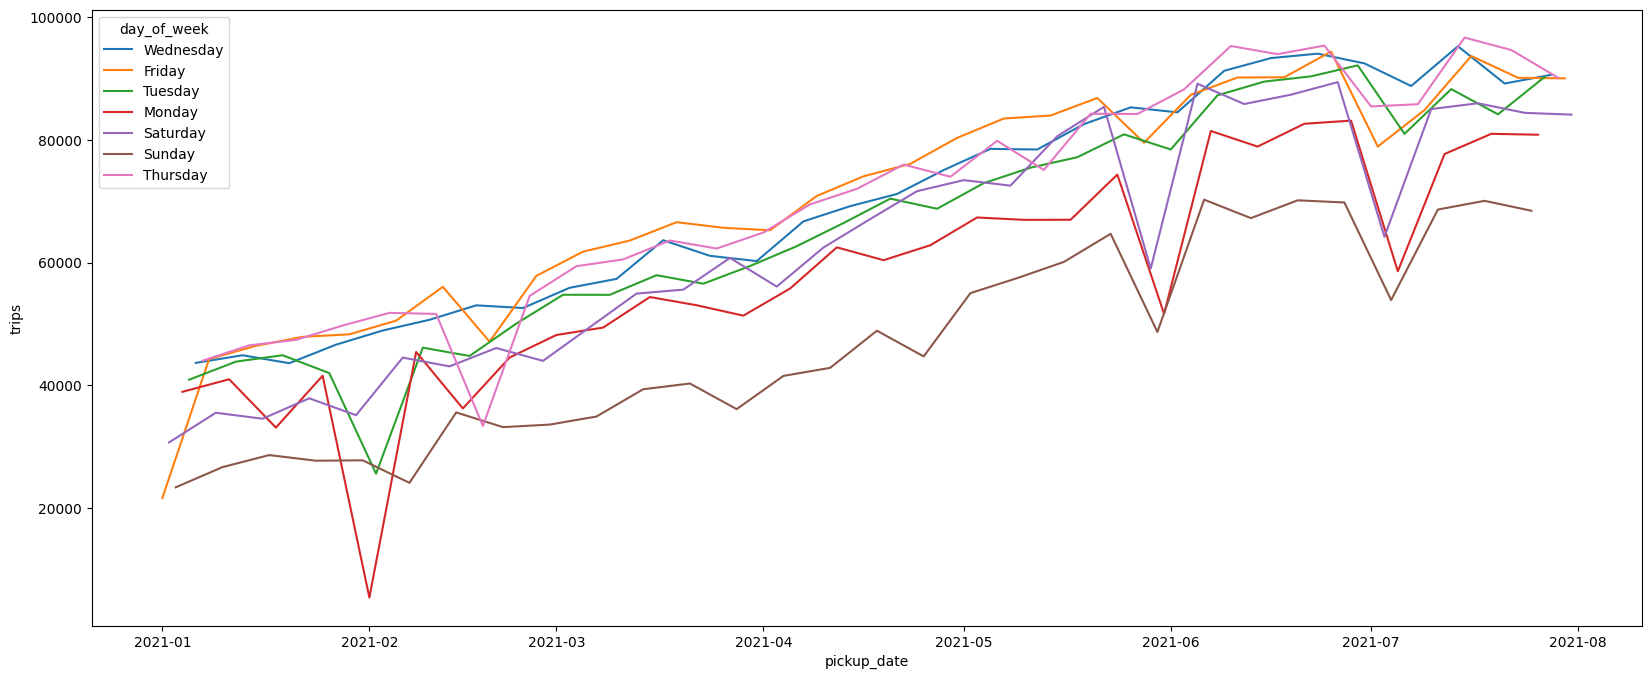

In [11]:
plt.subplots(figsize=(20, 8))
sns.lineplot(x='pickup_date', y='trips', hue='day_of_week', data=trips_day_of_week_pdf)
plt.show()

In [12]:
# 요일 별 중간 값 확인
median_data = trips_day_of_week_pdf.groupby("day_of_week")['trips'].median().to_frame()
median_data = median_data.reset_index()
median_data

,day_of_week,trips
0,Friday,74073.0
1,Monday,57168.5
2,Saturday,62455.0
3,Sunday,43749.0
4,Thursday,73015.0
5,Tuesday,67614.5
6,Wednesday,70196.0


In [13]:
# 요일 정렬(일월화수목금토)
median_data["sort_dow"] = median_data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})
median_data

,day_of_week,trips,sort_dow
0,Friday,74073.0,5
1,Monday,57168.5,1
2,Saturday,62455.0,6
3,Sunday,43749.0,0
4,Thursday,73015.0,4
5,Tuesday,67614.5,2
6,Wednesday,70196.0,3


In [14]:
median_data = median_data.sort_values(by='sort_dow')
median_data

,day_of_week,trips,sort_dow
3,Sunday,43749.0,0
1,Monday,57168.5,1
5,Tuesday,67614.5,2
6,Wednesday,70196.0,3
4,Thursday,73015.0,4
0,Friday,74073.0,5
2,Saturday,62455.0,6


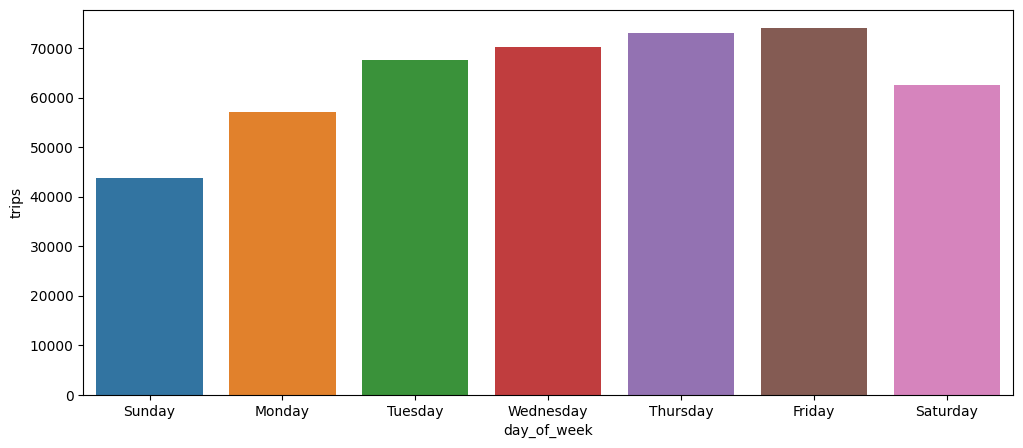

In [15]:
plt.subplots(figsize=(12, 5))
sns.barplot(x='day_of_week', y='trips', data=median_data)
plt.show()

In [16]:
# 결제 유형 별 분석
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}

def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

In [17]:
parse_payment_type(3)

'No Charge'

In [18]:
# 결제 타입을 스파크에서 사용할 수 있도록 UDF 등록
spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [19]:
query = """
SELECT parse_payment_type(payment_type),
       count(*) as trips,
       mean(fare_amount) as mean_fare_amount,
       std(fare_amount) as std_fare_amount

FROM cleaned
GROUP BY payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount|   std_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10264367| 12.23131695895088|10.873451774072866|
|                       No Charge|   59145|11.978582804970836|15.075633897695056|
|                         Dispute|   23806|12.730067209947066|14.892785718894652|
|                            Cash| 3152207|12.020139365847463| 11.75093016994253|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+



In [20]:
spark.stop()